In [13]:
# imports and load model
import torch
import torchvision
from torchvision.utils import draw_bounding_boxes

from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
import os

best = 'best.pt'
model = YOLO(best)
default = YOLO('yolov5su.pt')

In [ ]:
# compare model result for trained model and default model

rand = f"{random.randint(0, 3)}0{random.randint(0, 9)}{random.randint(0, 9)}{random.randint(0, 9)}"
# x = 'nfl-test-images.v1i.yolov7pytorch/val/images/00241_jpg.rf.c5c809431171c114f5d2051dd91275bd.jpg'
x = f'frames/{20159}.jpg'

img = torchvision.io.read_image(x)
results_m = model(x)
results_d = default(x, classes = 0)

for result in results_m:
    boxes_m = result.boxes

for result in results_d:
    boxes_d = result.boxes


print(x)
box_m = draw_bounding_boxes(img, boxes=boxes_m.xyxy,
                          colors="blue",
                          width=4)
box_d = draw_bounding_boxes(img, boxes=boxes_d.xyxy,
                            colors="red",
                            width=4)

fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].imshow(box_m.permute(1, 2, 0)); ax[0].axis('off'); ax[0].set_title(f'Best, {boxes_m.shape[0]} players detected')
ax[1].imshow(box_d.permute(1, 2, 0)); ax[1].axis('off'); ax[1].set_title(f'Default, {boxes_d.shape[0]} players detected')
plt.show()

In [5]:
def get_box_xywh(image, model):
    results = model(image, classes = 0)
    for result in results:
        boxes = result.boxes
    boxes = boxes.xyxy

    x = cv2.imread(image).shape[1]
    y = cv2.imread(image).shape[0]
    x_center = ((boxes[:, 0] + boxes[:, 2]) / 2) / x
    y_center = ((boxes[:, 1] + boxes[:, 3]) / 2) / y
    width = (boxes[:, 2] - boxes[:, 0]) / x
    height = (boxes[:, 3] - boxes[:, 1]) / y

    array = np.column_stack((np.zeros(boxes.shape[0]), x_center.numpy(), y_center.numpy(), width.numpy(), height.numpy()))
    return array

In [6]:
def get_box_xyxy(boxes):
    boxes_tensor = torch.zeros((len(boxes), 4)) 
    for i, box in enumerate(boxes):
        _, x_center, y_center, width, height = box
        
        x_min = (x_center - width / 2) * x
        y_min = (y_center - height / 2) * y
        x_max = (x_center + width / 2 ) * x
        y_max = (y_center + height / 2 ) * y
        
        boxes_tensor[i] = torch.tensor([x_min, y_min, x_max, y_max])
    return boxes_tensor

In [7]:
def get_iou(ground_truth_boxes, predicted_boxes):
    iou_matrix = torch.zeros((len(ground_truth_boxes), len(predicted_boxes)))
    for i, gt_box in enumerate(ground_truth_boxes):
        for j, pred_box in enumerate(predicted_boxes):
            pred_class, pred_xc, pred_yc, pred_w, pred_h = pred_box
            gt_class, gt_xc, gt_yc, gt_w, gt_h = gt_box
            
            xmin_pred = pred_xc - pred_w / 2
            ymin_pred = pred_yc - pred_h / 2
            xmax_pred = pred_xc + pred_w / 2
            ymax_pred = pred_yc + pred_h / 2
            
            xmin_gt = gt_xc - gt_w / 2
            ymin_gt = gt_yc - gt_h / 2
            xmax_gt = gt_xc + gt_w / 2
            ymax_gt = gt_yc + gt_h / 2
            
            intersection_area = max(0, min(xmax_pred, xmax_gt) - max(xmin_pred, xmin_gt)) * max(0, min(ymax_pred, ymax_gt) - max(ymin_pred, ymin_gt))
            union_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred) + (xmax_gt - xmin_gt) * (ymax_gt - ymin_gt) - intersection_area
            iou = intersection_area / union_area if union_area > 0 else 0
            
            iou_matrix[i, j] = iou


    row_ind, col_ind = linear_sum_assignment(-iou_matrix.numpy())  # finding row/column pair that has highest iou
    iou_matrix = []

    for i, j in zip(row_ind, col_ind):
        gt_box = ground_truth_boxes[i]
        pred_box = predicted_boxes[j]
        
        pred_class, pred_xc, pred_yc, pred_w, pred_h = pred_box
        gt_class, gt_xc, gt_yc, gt_w, gt_h = gt_box
        
        xmin_pred = pred_xc - pred_w / 2
        ymin_pred = pred_yc - pred_h / 2
        xmax_pred = pred_xc + pred_w / 2
        ymax_pred = pred_yc + pred_h / 2
        
        xmin_gt = gt_xc - gt_w / 2
        ymin_gt = gt_yc - gt_h / 2
        xmax_gt = gt_xc + gt_w / 2
        ymax_gt = gt_yc + gt_h / 2
        
        intersection_area = max(0, min(xmax_pred, xmax_gt) - max(xmin_pred, xmin_gt)) * max(0, min(ymax_pred, ymax_gt) - max(ymin_pred, ymin_gt))
        union_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred) + (xmax_gt - xmin_gt) * (ymax_gt - ymin_gt) - intersection_area
        iou = intersection_area / union_area if union_area > 0 else 0
        iou_matrix.append([i, j, iou])
        
    return iou_matrix

In [11]:
# comparing best and default models to ground truth labels
path = '00039'
img = f'nfl-test-images.v1i.yolov7pytorch/val/images/{path}.jpg'
labels = f'nfl-test-images.v1i.yolov7pytorch/val/labels/{path}.txt'

model_boxes = get_box_xywh(img, model)
default_boxes = get_box_xywh(img, default)

with open(labels, 'r') as file:
    lines = file.readlines()

ground_truth_boxes = []
for line in lines:
    values = line.strip().split()
    ground_truth_boxes.append([int(values[0]), float(values[1]), float(values[2]), float(values[3]), float(values[4])])

x = cv2.imread(img).shape[1]
y = cv2.imread(img).shape[0]

gt_tensor = get_box_xyxy(ground_truth_boxes)
model_tensor = get_box_xyxy(model_boxes)
default_tensor = get_box_xyxy(default_boxes)


image 1/1 /Users/tsigall/Repositories/dsan6600/nfl-test-images.v1i.yolov7pytorch/val/images/00039.jpg: 736x1280 20 players, 232.1ms
Speed: 2.6ms preprocess, 232.1ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /Users/tsigall/Repositories/dsan6600/nfl-test-images.v1i.yolov7pytorch/val/images/00039.jpg: 384x640 2 persons, 67.6ms
Speed: 1.3ms preprocess, 67.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


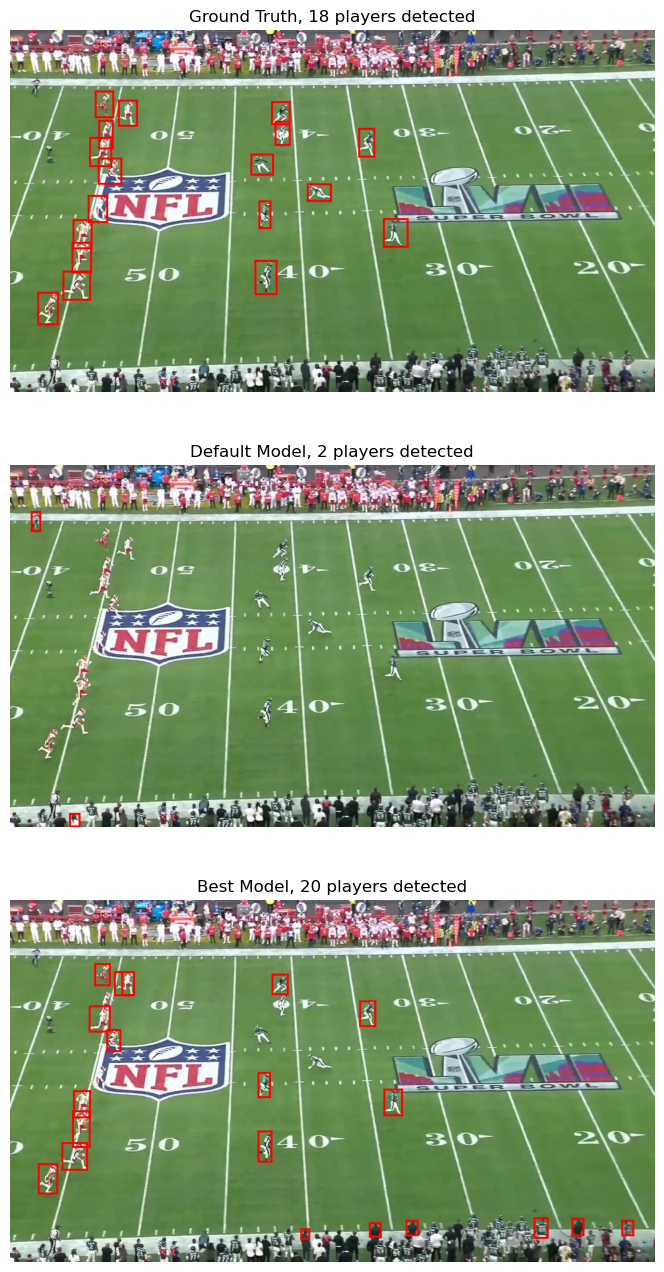

In [12]:
# visualize results
box_gt = draw_bounding_boxes(torchvision.io.read_image(img), boxes=gt_tensor,
                          colors="red",
                          width=4)

box_pred = draw_bounding_boxes(torchvision.io.read_image(img), boxes=model_tensor,
                            colors="red",
                            width=4)

box_model = draw_bounding_boxes(torchvision.io.read_image(img), boxes=default_tensor,
                            colors="red",
                            width=4)


fig, ax = plt.subplots(3, 1, figsize=(9, 16))
ax[0].imshow(box_gt.permute(1, 2, 0)); ax[0].axis('off'); ax[0].set_title(f'Ground Truth, {len(ground_truth_boxes)} players detected')
ax[1].imshow(box_model.permute(1, 2, 0)); ax[1].axis('off'); ax[1].set_title(f'Default Model, {len(default_boxes)} players detected')
ax[2].imshow(box_pred.permute(1, 2, 0)); ax[2].axis('off'); ax[2].set_title(f'Best Model, {len(model_boxes)} players detected')
plt.savefig(f'output_plots/{path}.png')
plt.show()

In [ ]:
# calculate mean iou for both models
folder_path = 'nfl-test-images.v1i.yolov7pytorch/val/images'
files = os.listdir(folder_path)

model_ious = []
default_ious = []

for file in files:
    path = file[0:5]
    img = f'nfl-test-images.v1i.yolov7pytorch/val/images/{path}.jpg'
    labels = f'nfl-test-images.v1i.yolov7pytorch/val/labels/{path}.txt'

    model_boxes = get_box_xywh(img, model)
    default_boxes = get_box_xywh(img, default)

    with open(labels, 'r') as file:
        lines = file.readlines()

    ground_truth_boxes = []
    for line in lines:
        values = line.strip().split()
        ground_truth_boxes.append([int(values[0]), float(values[1]), float(values[2]), float(values[3]), float(values[4])])

    iou_list_model = get_iou(ground_truth_boxes, model_boxes)
    iou_list_default = get_iou(ground_truth_boxes, default_boxes)

    iou_list_model = [iou[2] for iou in iou_list_model]
    iou_list_default = [iou[2] for iou in iou_list_default]
    
    model_ious.append(np.mean(iou_list_model))
    default_ious.append(np.mean(iou_list_default))

In [15]:
# display result
print(f"best model iou: {round(np.mean(model_ious), 4)}")
print(f"default model iou: {round(np.mean(default_ious), 4)}")

best model iou: 0.681
default model iou: 0.5666



image 1/1 /Users/tsigall/Repositories/dsan6600/datasets/teacher/images/train/30201.jpg: 736x1280 54 players, 220.7ms
Speed: 3.5ms preprocess, 220.7ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /Users/tsigall/Repositories/dsan6600/datasets/teacher/images/train/30201.jpg: 384x640 20 persons, 63.2ms
Speed: 1.0ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


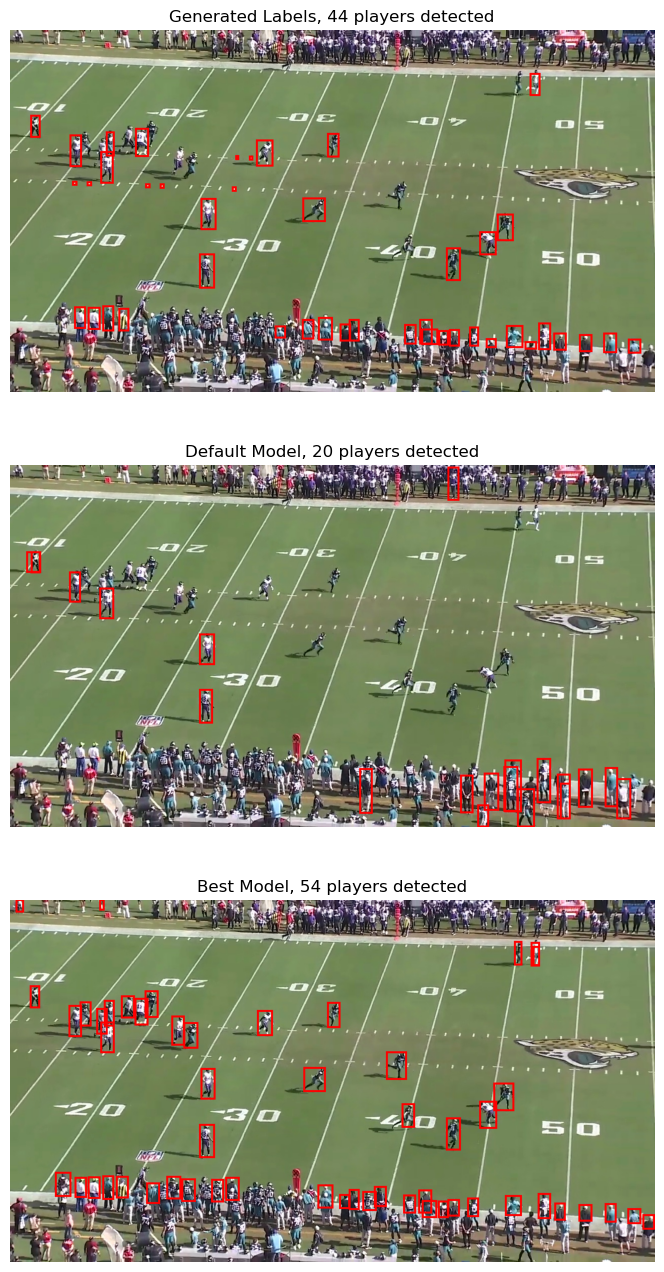

In [18]:
# compare best and default models to generated labels
path = 'train/30201'
img = f'datasets/teacher/images/{path}.jpg'
labels = f'datasets/teacher/labels/{path}.txt'

model_boxes = get_box_xywh(img, model)
default_boxes = get_box_xywh(img, default)

with open(labels, 'r') as file:
    lines = file.readlines()

ground_truth_boxes = []
for line in lines:
    values = line.strip().split()
    ground_truth_boxes.append([int(values[0]), float(values[1]), float(values[2]), float(values[3]), float(values[4])])

x = cv2.imread(img).shape[1]
y = cv2.imread(img).shape[0]

gt_tensor = get_box_xyxy(ground_truth_boxes)
model_tensor = get_box_xyxy(model_boxes)
default_tensor = get_box_xyxy(default_boxes)

box_gt = draw_bounding_boxes(torchvision.io.read_image(img), boxes=gt_tensor,
                          colors="red",
                          width=4)

box_pred = draw_bounding_boxes(torchvision.io.read_image(img), boxes=model_tensor,
                            colors="red",
                            width=4)

box_model = draw_bounding_boxes(torchvision.io.read_image(img), boxes=default_tensor,
                            colors="red",
                            width=4)


fig, ax = plt.subplots(3, 1, figsize=(9, 16))
ax[0].imshow(box_gt.permute(1, 2, 0)); ax[0].axis('off'); ax[0].set_title(f'Generated Labels, {len(ground_truth_boxes)} players detected')
ax[1].imshow(box_model.permute(1, 2, 0)); ax[1].axis('off'); ax[1].set_title(f'Default Model, {len(default_boxes)} players detected')
ax[2].imshow(box_pred.permute(1, 2, 0)); ax[2].axis('off'); ax[2].set_title(f'Best Model, {len(model_boxes)} players detected')
# plt.savefig(f'output_plots/{path}.png')
plt.show()